In [2]:
# Imports
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, random_split

import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt

import copy
import os
import time

cudnn.benchmark = True

In [3]:
# Constants
VAL_SIZE = 0.15
TEST_SIZE = 0.15
SEED = 490

In [4]:
torch.manual_seed(SEED)
np.random.seed(SEED)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
data_dir = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset'

In [7]:
# Create datasets
image_dataset = datasets.ImageFolder(data_dir, transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]))

In [8]:
print(image_dataset)

Dataset ImageFolder
    Number of datapoints: 75000
    Root location: /kaggle/input/rice-image-dataset/Rice_Image_Dataset
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [9]:
val_length = int(len(image_dataset) * VAL_SIZE)
test_length = int(len(image_dataset) * TEST_SIZE)
train_length = len(image_dataset) - (val_length + test_length)
train_dataset, val_dataset, test_dataset = random_split(image_dataset, [train_length, val_length, test_length])

In [10]:
image_datasets = {
    'train': train_dataset,
    'val': val_dataset,
    'test': test_dataset
}
dataset_sizes = { x: len(image_datasets[x]) for x in ['train', 'val', 'test'] }

In [11]:
dataloaders = { x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=x!='test', num_workers=2)
              for x in ['train', 'val', 'test'] }

In [12]:
class_names = image_datasets['train'].dataset.classes
print(class_names)

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


In [13]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

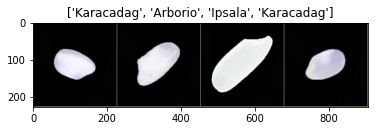

<Figure size 432x288 with 0 Axes>

In [14]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from the batch
out = torchvision.utils.make_grid(inputs[:4])

# Display the images
imshow(out, title=[class_names[x] for x in classes[:4]])
plt.savefig('Examples.png')

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        epoch_start = time.time()

        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        epoch_time = time.time() - epoch_start
        print(f'Epoch time: {epoch_time // 60:.0f}m {epoch_time % 60:.0f}s')
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [16]:
def get_test_accuracy(model):
    correct = 0
    
    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            correct += torch.sum(preds == labels.data)
    
    accuracy = correct.double() / dataset_sizes['test']
    
    print(f'Test accuracy: {accuracy:4f}')
    
    return accuracy

In [17]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# ResNet18 with SGD

In [18]:
resnet1 = torchvision.models.resnet18(pretrained=True)
for param in resnet1.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = resnet1.fc.in_features
resnet1.fc = nn.Linear(num_ftrs, len(class_names))

resnet1 = resnet1.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer = optim.SGD(resnet1.fc.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [19]:
resnet1, r1_train_loss, r1_val_loss, r1_train_acc, r1_val_acc = train_model(
    resnet1, criterion, optimizer, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 1.7948 Acc: 0.8329
val Loss: 0.4222 Acc: 0.9601
Epoch time: 5m 26s

Epoch 1/19
----------
train Loss: 1.6258 Acc: 0.8675
val Loss: 0.3399 Acc: 0.9668
Epoch time: 4m 22s

Epoch 2/19
----------
train Loss: 1.5490 Acc: 0.8738
val Loss: 0.6997 Acc: 0.9360
Epoch time: 4m 21s

Epoch 3/19
----------
train Loss: 1.6495 Acc: 0.8723
val Loss: 1.8875 Acc: 0.8940
Epoch time: 4m 20s

Epoch 4/19
----------
train Loss: 1.6084 Acc: 0.8782
val Loss: 1.3785 Acc: 0.8891
Epoch time: 4m 20s

Epoch 5/19
----------
train Loss: 1.6074 Acc: 0.8786
val Loss: 0.3893 Acc: 0.9701
Epoch time: 4m 20s

Epoch 6/19
----------
train Loss: 1.5133 Acc: 0.8850
val Loss: 1.0284 Acc: 0.9341
Epoch time: 4m 19s

Epoch 7/19
----------
train Loss: 0.8881 Acc: 0.9182
val Loss: 0.4593 Acc: 0.9556
Epoch time: 4m 19s

Epoch 8/19
----------
train Loss: 0.7889 Acc: 0.9186
val Loss: 0.3780 Acc: 0.9630
Epoch time: 4m 17s

Epoch 9/19
----------
train Loss: 0.7600 Acc: 0.9151
val Loss: 0.4678 Acc: 0.9519


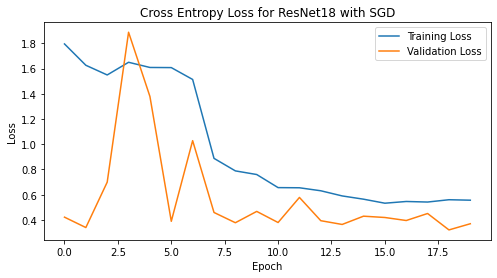

In [20]:
plt.figure(figsize=(8, 4))
plt.plot(r1_train_loss, label='Training Loss')
plt.plot(r1_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Cross Entropy Loss for ResNet18 with SGD')
plt.savefig('ResNet18 SGD Loss.png')
plt.show()

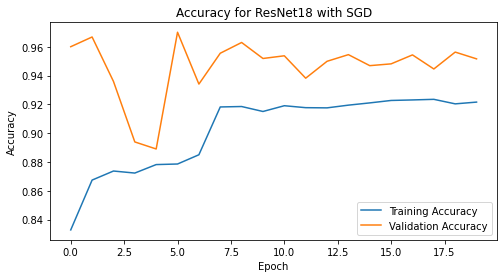

In [21]:
plt.figure(figsize=(8, 4))
plt.plot([acc.cpu() for acc in r1_train_acc], label='Training Accuracy')
plt.plot([acc.cpu() for acc in r1_val_acc], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy for ResNet18 with SGD')
plt.savefig('ResNet18 SGD Accuracy.png')
plt.show()

In [22]:
torch.save(resnet1.state_dict(), 'resnet1.pth')

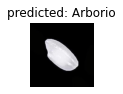

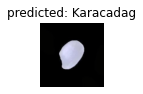

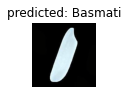

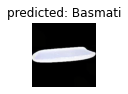

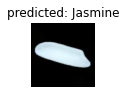

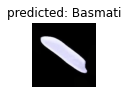

In [23]:
visualize_model(resnet1)

plt.show()

In [24]:
r1_test_accuracy = get_test_accuracy(resnet1)

Test accuracy: 0.969778


# ResNet18 with Adadelta

In [25]:
resnet2 = torchvision.models.resnet18(pretrained=True)
for param in resnet2.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = resnet2.fc.in_features
resnet2.fc = nn.Linear(num_ftrs, len(class_names))

resnet2 = resnet2.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer = optim.Adadelta(resnet2.fc.parameters(), lr=0.01)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [26]:
resnet2, r2_train_loss, r2_val_loss, r2_train_acc, r2_val_acc = train_model(
    resnet2, criterion, optimizer, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 0.7876 Acc: 0.7570
val Loss: 0.2901 Acc: 0.9178
Epoch time: 4m 14s

Epoch 1/19
----------
train Loss: 0.4897 Acc: 0.8433
val Loss: 0.1775 Acc: 0.9519
Epoch time: 4m 14s

Epoch 2/19
----------
train Loss: 0.4276 Acc: 0.8549
val Loss: 0.1455 Acc: 0.9592
Epoch time: 4m 14s

Epoch 3/19
----------
train Loss: 0.3940 Acc: 0.8629
val Loss: 0.1605 Acc: 0.9417
Epoch time: 4m 14s

Epoch 4/19
----------
train Loss: 0.3809 Acc: 0.8648
val Loss: 0.1169 Acc: 0.9642
Epoch time: 4m 14s

Epoch 5/19
----------
train Loss: 0.3633 Acc: 0.8715
val Loss: 0.1153 Acc: 0.9670
Epoch time: 4m 14s

Epoch 6/19
----------
train Loss: 0.3563 Acc: 0.8719
val Loss: 0.1428 Acc: 0.9493
Epoch time: 4m 14s

Epoch 7/19
----------
train Loss: 0.3518 Acc: 0.8729
val Loss: 0.1199 Acc: 0.9593
Epoch time: 4m 14s

Epoch 8/19
----------
train Loss: 0.3496 Acc: 0.8737
val Loss: 0.1122 Acc: 0.9646
Epoch time: 4m 13s

Epoch 9/19
----------
train Loss: 0.3516 Acc: 0.8732
val Loss: 0.1143 Acc: 0.9667


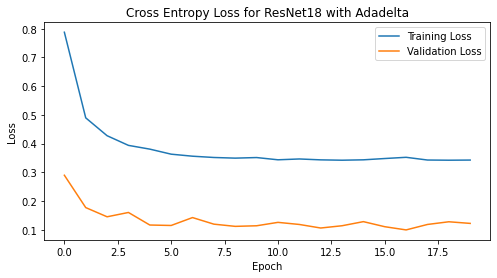

In [27]:
plt.figure(figsize=(8, 4))
plt.plot(r2_train_loss, label='Training Loss')
plt.plot(r2_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Cross Entropy Loss for ResNet18 with Adadelta')
plt.savefig('ResNet18 Adadelta Loss.png')
plt.show()

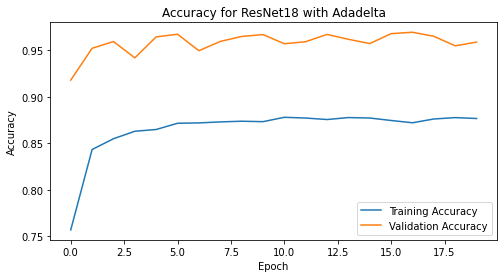

In [28]:
plt.figure(figsize=(8, 4))
plt.plot([acc.cpu() for acc in r2_train_acc], label='Training Accuracy')
plt.plot([acc.cpu() for acc in r2_val_acc], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy for ResNet18 with Adadelta')
plt.savefig('ResNet18 Adadelta Accuracy.png')
plt.show()

In [29]:
torch.save(resnet2.state_dict(), 'resnet2.pth')

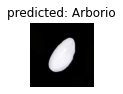

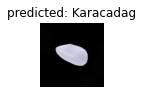

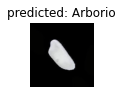

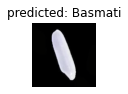

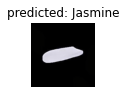

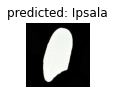

In [30]:
visualize_model(resnet2)

plt.show()

In [31]:
r2_test_accuracy = get_test_accuracy(resnet2)

Test accuracy: 0.969422


# ResNet18 with RMSprop

In [32]:
resnet3 = torchvision.models.resnet18(pretrained=True)
for param in resnet3.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = resnet3.fc.in_features
resnet3.fc = nn.Linear(num_ftrs, len(class_names))

resnet3 = resnet3.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer = optim.RMSprop(resnet3.fc.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [33]:
resnet3, r3_train_loss, r3_val_loss, r3_train_acc, r3_val_acc = train_model(
    resnet3, criterion, optimizer, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 12.2155 Acc: 0.8261
val Loss: 1.8496 Acc: 0.9722
Epoch time: 4m 11s

Epoch 1/19
----------
train Loss: 12.3537 Acc: 0.8599
val Loss: 11.0749 Acc: 0.8975
Epoch time: 4m 11s

Epoch 2/19
----------
train Loss: 12.2878 Acc: 0.8678
val Loss: 5.4010 Acc: 0.9491
Epoch time: 4m 11s

Epoch 3/19
----------
train Loss: 11.8714 Acc: 0.8747
val Loss: 7.0761 Acc: 0.9316
Epoch time: 4m 13s

Epoch 4/19
----------
train Loss: 12.3600 Acc: 0.8761
val Loss: 3.6519 Acc: 0.9563
Epoch time: 4m 12s

Epoch 5/19
----------
train Loss: 12.0354 Acc: 0.8786
val Loss: 6.1835 Acc: 0.9350
Epoch time: 4m 12s

Epoch 6/19
----------
train Loss: 12.6052 Acc: 0.8771
val Loss: 3.4753 Acc: 0.9544
Epoch time: 4m 12s

Epoch 7/19
----------
train Loss: 6.3996 Acc: 0.9181
val Loss: 3.4425 Acc: 0.9503
Epoch time: 4m 12s

Epoch 8/19
----------
train Loss: 5.6473 Acc: 0.9202
val Loss: 2.6521 Acc: 0.9592
Epoch time: 4m 15s

Epoch 9/19
----------
train Loss: 5.3884 Acc: 0.9166
val Loss: 2.4588 Acc:

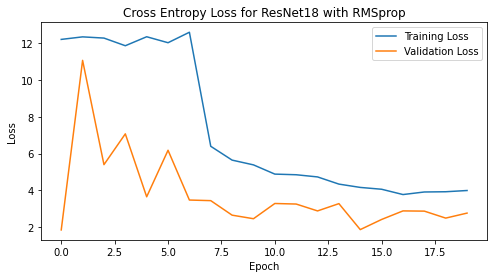

In [34]:
plt.figure(figsize=(8, 4))
plt.plot(r3_train_loss, label='Training Loss')
plt.plot(r3_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Cross Entropy Loss for ResNet18 with RMSprop')
plt.savefig('ResNet18 RMSprop Loss.png')
plt.show()

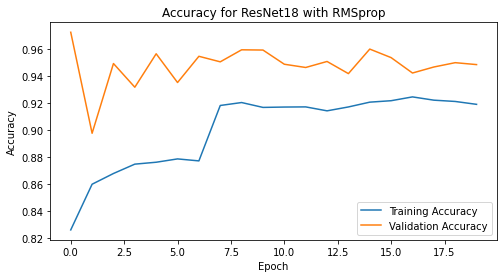

In [35]:
plt.figure(figsize=(8, 4))
plt.plot([acc.cpu() for acc in r3_train_acc], label='Training Accuracy')
plt.plot([acc.cpu() for acc in r3_val_acc], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy for ResNet18 with RMSprop')
plt.savefig('ResNet18 RMSprop Accuracy.png')
plt.show()

In [36]:
torch.save(resnet3.state_dict(), 'resnet3.pth')

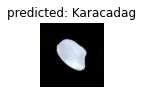

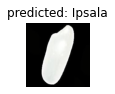

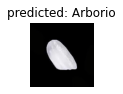

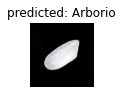

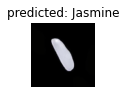

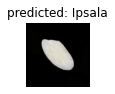

In [37]:
visualize_model(resnet3)

plt.show()

In [38]:
r3_test_accuracy = get_test_accuracy(resnet3)

Test accuracy: 0.972178
